In [ ]:
import sklearn
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
import xgboost as xgb
import matplotlib.pyplot as plt
import re
#import text2vec

In [ ]:
columns = ['Unnamed: 0', 'author', 'id', 'selftext', 'subreddit', 'subreddit_id',
           'title', 'Country', 'selftext_NO_PUNC', 'title_NO_PUNC', 'fentanyl',
           'count_fentanyl', 'heroin', 'count_heroin', 'oxy', 'count_oxy', 'MDMA',
           'count_MDMA', 'INHALANTS', 'count_INHALANTS', 'GHB', 'count_GHB',
           'COCAINE', 'count_COCAINE', 'marijuana', 'count_marijuana',
           'total_flags', 'match', 'total_text_no_punc', 'total_text',
           'concat', 'total_no_drug', 'year']

# Create an empty DataFrame with the specified columns
balanced_sample = pd.DataFrame(columns=columns)
no_included_samples = pd.DataFrame(columns=columns)


In [ ]:
def balanced_sample_maker(csv, balanced, left_overs, un_balancer):
    file_path_submission = csv
    submissions = pd.read_csv(file_path_submission)
    submissions['year'] = file_path_submission[-11:-7]


    #submissions = submissions[submissions['no_match'] == 0]
    #submissions['match'] = np.where(submissions['no_match'] == 0, 1,0)

    #submissions['match'] = submissions['no_match']
    submissions[submissions['selftext'] != '[removed]']
    submissions[submissions['selftext'] != '[deleted]']
    submissions['selftext'] = submissions['selftext'].fillna(' ')
    submissions['title'] = submissions['title'].fillna(' ')
    submissions['selftext_NO_PUNC'] = submissions['selftext_NO_PUNC'].fillna(' ')
    submissions['title_NO_PUNC'] = submissions['title_NO_PUNC'].fillna(' ')
    #submissions
    submissions['total_text_no_punc'] = submissions['title_NO_PUNC'] + " " + submissions['selftext_NO_PUNC']
    submissions['total_text'] = submissions['title'] + " " + submissions['selftext']

    submissions = submissions[~submissions['total_text'].str.contains('\[removed\]', case=False)]
    submissions = submissions[~submissions['total_text'].str.contains('\[deleted\]', case=False)]
    removed_pattern = re.compile(r'\[r(e|m)(o|0)v(e|a)ed\]', flags=re.IGNORECASE)
# Filter out rows containing '[removed]' variations in the 'total_text' column
    submissions = submissions[~submissions['total_text'].str.extract(removed_pattern).notna().any(axis=1)]

    lst = submissions.columns.tolist()

    # Splitting column names by commas and flattening the resulting list
    split_columns = [item.split(',') for item in lst]
    flattened_list = [item for sublist in split_columns for item in sublist]

    filtered_list = [item for item in flattened_list[flattened_list.index('title_NO_PUNC') + 1:]]
    filtered_list = [item for item in filtered_list if "count_" not in item]
    filtered_list = [item for item in filtered_list[:filtered_list.index('total_flags'):]]

    submissions['concat'] = submissions[filtered_list].values.tolist()

    submissions['concat'] = submissions['concat'].apply(lambda x: [item for item in x if pd.notna(item)])

    submissions['concat'] = submissions['concat'].apply(lambda x: [item.strip() for sublist in x for item in sublist.split(',')] if x else [])

    def remove_occurrences(row):
        for item in row['concat']:
            # Create a regular expression pattern for whole-word match with case-insensitive flag
            pattern = r'\b{}\b'.format(re.escape(item))
            # Use re.sub to replace occurrences based on the pattern
            row['total_text_no_punc'] = re.sub(pattern, '', row['total_text_no_punc'], flags=re.IGNORECASE)
        return row['total_text_no_punc']

    # Apply the function to each row
    submissions['total_no_drug'] = submissions.apply(remove_occurrences, axis=1)

    def compbl(s):
        return ' '.join(s.split())

    submissions['total_no_drug'] = submissions['total_no_drug'].apply(compbl)


    drug_summary = submissions.columns.tolist()
    count_columns = [col for col in drug_summary if col.startswith('count_')]
    #submissions = submissions[submissions['total_text'].str.contains(re.escape('[removed]'))]
    n = int(round(submissions['match'].sum() * un_balancer))
    sample_no_drug = submissions[submissions['match'] == 0].sample(n)
    not_selected_samples = submissions[~submissions.index.isin(sample_no_drug.index)]
    #keeping not included samples
    sample_drug = submissions[submissions['match'] == 1]
    balanced = pd.concat([sample_drug,sample_no_drug], ignore_index = True)

    print("total drug related content {}, total length of balanced dataset {}".format(submissions['match'].sum(), len(balanced)))
    return balanced, not_selected_samples


In [ ]:
import glob
folder = 'C:/Users/Jonathon/OneDrive/UVA/Data System Project/reddit_csv/submission2_cleaned/'
for x in glob.glob('{}\*.csv'.format(folder)):
    bal, ns = balanced_sample_maker(x,
                          balanced_sample,
                         no_included_samples,
                         1.5)
    no_included_samples = pd.concat([no_included_samples,ns], ignore_index = True)
    balanced_sample = pd.concat([balanced_sample, bal], ignore_index = True)


total drug related content 665, total length of balanced dataset 1663


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 651, total length of balanced dataset 1627
total drug related content 757, total length of balanced dataset 1893
total drug related content 856, total length of balanced dataset 2140


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (10,20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 774, total length of balanced dataset 1935


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 700, total length of balanced dataset 1750
total drug related content 759, total length of balanced dataset 1897


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 695, total length of balanced dataset 1737
total drug related content 759, total length of balanced dataset 1897


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 802, total length of balanced dataset 2005
total drug related content 868, total length of balanced dataset 2170
total drug related content 1033, total length of balanced dataset 2583
total drug related content 1063, total length of balanced dataset 2657
total drug related content 945, total length of balanced dataset 2363


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 891, total length of balanced dataset 2227
total drug related content 890, total length of balanced dataset 2225


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 835, total length of balanced dataset 2087


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 707, total length of balanced dataset 1767


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 645, total length of balanced dataset 1613
total drug related content 683, total length of balanced dataset 1707
total drug related content 723, total length of balanced dataset 1807
total drug related content 769, total length of balanced dataset 1923
total drug related content 813, total length of balanced dataset 2033
total drug related content 959, total length of balanced dataset 2397
total drug related content 855, total length of balanced dataset 2137
total drug related content 819, total length of balanced dataset 2047


C:\Users\Jonathon\AppData\Local\Temp\ipykernel_20796\933744003.py:3: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  submissions = pd.read_csv(file_path_submission)


total drug related content 965, total length of balanced dataset 2413
total drug related content 957, total length of balanced dataset 2393
total drug related content 933, total length of balanced dataset 2333
total drug related content 825, total length of balanced dataset 2063
total drug related content 838, total length of balanced dataset 2095
total drug related content 887, total length of balanced dataset 2217
total drug related content 808, total length of balanced dataset 2020
total drug related content 857, total length of balanced dataset 2143
total drug related content 753, total length of balanced dataset 1883
total drug related content 1077, total length of balanced dataset 2693
total drug related content 858, total length of balanced dataset 2145
total drug related content 724, total length of balanced dataset 1810
total drug related content 860, total length of balanced dataset 2150
total drug related content 759, total length of balanced dataset 1897
total drug related 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


In [ ]:
import pandas as pd
balanced_sample = pd.read_csv('/content/drive/MyDrive/reddit/balanced_submission/balance_sample_sub.csv')
no_included_samples = pd.read_csv('/content/drive/MyDrive/reddit/balanced_submission/no_include_sample_sub.csv')


<ipython-input-2-06e46dea15cf>:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  balanced_sample = pd.read_csv('/content/drive/MyDrive/reddit/balanced_submission/balance_sample_sub.csv')
<ipython-input-2-06e46dea15cf>:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  no_included_samples = pd.read_csv('/content/drive/MyDrive/reddit/balanced_submission/no_include_sample_sub.csv')


In [ ]:
balanced_sample = balanced_sample[balanced_sample['total_no_drug'].notna()]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report

# Sample data - replace this with your own dataset
texts = balanced_sample['total_no_drug'].tolist()

labels = balanced_sample['match'].tolist()

# Unpack and create a single list
#flat_list = sorted(set([item for subset in labels for item in subset]))

# Convert the list to a set to remove duplicates and then sort it
#sorted_unique_list = sorted(set(flat_list))


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)
#X_train

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train a Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

# Make predictions on the test set
y_pred_bin = nb_classifier.predict(X_test_vec)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred_bin)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_bin, zero_division=1))
# labels = ['count_COCAINE', 'count_INHALANTS', 'count_MDMA', 'count_fentanyl', 'count_heroin', 'count_marijuana', 'count_oxy', 'no_match']
#target_names = sorted_unique_list

Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.66      0.75      9915
           1       0.66      0.85      0.74      7492

    accuracy                           0.74     17407
   macro avg       0.75      0.76      0.74     17407
weighted avg       0.77      0.74      0.74     17407



In [ ]:
#no_included_samples
no_sample_pre = no_included_samples['total_text'].tolist()
no_sample_pre_vec = vectorizer.transform(no_sample_pre)
no_sample_predictions = nb_classifier.predict(no_sample_pre_vec)


In [ ]:
no_included_samples['prediction_nb'] = no_sample_predictions


Index(['Unnamed: 0', 'author', 'id', 'selftext', 'subreddit', 'subreddit_id',
       'title', 'Country', 'selftext_NO_PUNC', 'title_NO_PUNC', 'fentanyl',
       'count_fentanyl', 'heroin', 'count_heroin', 'oxy', 'count_oxy', 'MDMA',
       'count_MDMA', 'INHALANTS', 'count_INHALANTS', 'GHB', 'count_GHB',
       'COCAINE', 'count_COCAINE', 'marijuana', 'count_marijuana',
       'total_flags', 'match', 'total_text_no_punc', 'total_text', 'concat',
       'total_no_drug', 'year'],
      dtype='object')

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score

# Sample data - replace this with your own dataset
texts = balanced_sample['total_no_drug'].tolist()
labels = balanced_sample['match'].tolist()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert text data to numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic')

# Fit the model on the training data
xgb_model.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test_vec)

# Calculate precision
precision = recall_score(y_test, y_pred)
print(f'recall : {precision}')

# Define parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3)

# Fit the grid search on the training data
grid_search.fit(X_train_vec, y_train)

# Get the best parameters and the best model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Make predictions on the test data using the tuned model
y_pred_tuned = best_model.predict(X_test_vec)

# Calculate precision for the tuned model
recall_tuned = recall_score(y_test, y_pred_tuned)
print(f'Tuned recall: {recall_tuned}')

no_sample_pre = no_included_samples['total_text'].tolist()
no_sample_pre_vec = vectorizer.transform(no_sample_pre)
check = best_model.predict(no_sample_pre_vec)
no_included_samples['xg_boost'] = check


recall : 0.6213294180459157
Tuned recall: 0.5927656166577683


In [ ]:

# Save the best model
best_model.save_model('/content/drive/MyDrive/reddit/xgb_model_post.model')

# Load the model from the saved file
#loaded_model = xgb.XGBClassifier()
#loaded_model.load_model('/content/drive/MyDrive/reddit/xgb_model.model')


#vectorizer = TfidfVectorizer(stop_words='english')
#X_train_vec = vectorizer.fit_transform(X_train)

# Make predictions using the loaded model
#y_pred_loaded = loaded_model.predict(X_test_vec)

# Calculate recall for the loaded model
#recall_loaded = recall_score(y_test, y_pred_loaded)
#print(f'Recall for loaded model: {recall_loaded}')



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:28:31] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


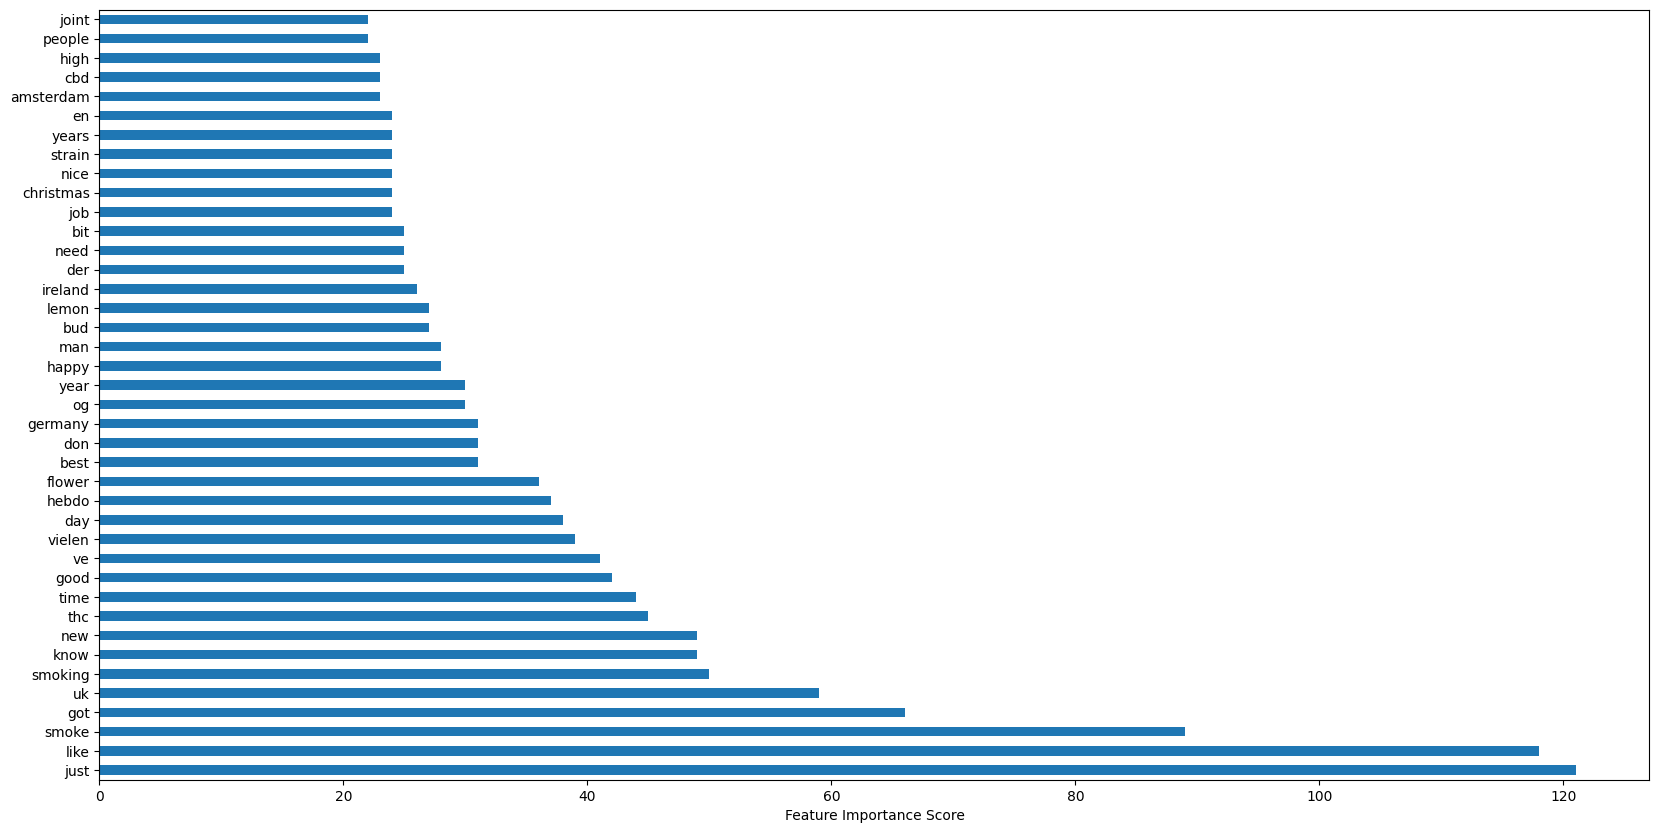

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have already imported necessary libraries and defined best_model, vectorizer

feature_importance = best_model.get_booster().get_score(importance_type='weight')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

# Map feature indices to feature names
feature_names = vectorizer.get_feature_names_out()
feature_names_mapped = [feature_names[int(key[1:])] for key in keys]

# Create a DataFrame for visualization
data = pd.DataFrame(data=values, index=feature_names_mapped, columns=["score"]).sort_values(by="score", ascending=False)

# Plot the top 40 features
data.nlargest(40, columns="score").plot(kind='barh', figsize=(20, 10), legend=False)
plt.xlabel('Feature Importance Score')
plt.show()  # Display the plot


In [ ]:
no_included_samples.to_csv('/content/drive/MyDrive/reddit/balanced_submission/no_include_sample_sub_nb_xg.csv')